In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
conn= engine.connect()

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()

In [7]:
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)

In [12]:
columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'])

id
station
date
prcp
tobs


In [13]:
columns = inspector.get_columns('Station')
for col in columns:
    print(col['name'])

id
station
name
latitude
longitude
elevation


# Exploratory Climate Analysis

In [14]:
# Calculate the date 1 year ago from the last data point in the database
last_date = engine.execute("select date from Measurement order by date desc limit 1")
for x in last_date:
    print(x)

('2017-08-23',)


In [15]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [16]:
#Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).all()

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
new_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df =pd.DataFrame(new_data, columns=['date','prcp'])
df.set_index(df['date'], inplace=True)
df=df.dropna()
df

,date,prcp
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,0.15
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.02
2016-08-23,2016-08-23,1.79
...,...,...
2017-08-22,2017-08-22,0.50
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00


In [19]:
data_02 = session.query(Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).all()

In [20]:
df_new =pd.DataFrame(data_02, columns=['date','prcp','station','tobs'])
df_new

,date,prcp,station,tobs
0,2010-01-01,0.08,USC00519397,65.0
1,2010-01-02,0.00,USC00519397,63.0
2,2010-01-03,0.00,USC00519397,74.0
3,2010-01-04,0.00,USC00519397,76.0
4,2010-01-06,NaN,USC00519397,73.0
...,...,...,...,...
19545,2017-08-19,0.09,USC00516128,71.0
19546,2017-08-20,NaN,USC00516128,78.0
19547,2017-08-21,0.56,USC00516128,76.0
19548,2017-08-22,0.50,USC00516128,76.0


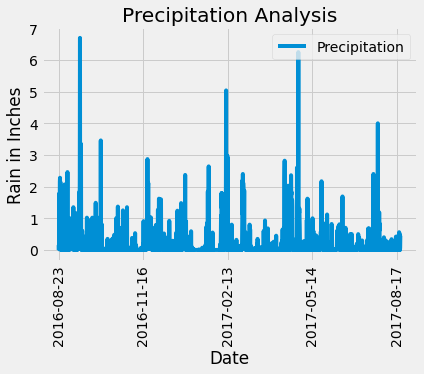

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"], loc='upper right')
plt.xticks(rotation=90)
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().all()
print(len(station_count))

9


In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station =='USC00519523').all()
highest_temp = session.query(func.max(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station =='USC00519523').all()
avg_temp = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station =='USC00519523').all()
print(lowest_temp, highest_temp, avg_temp)

[(56.0,)] [(85.0,)] [(74.5436493068565,)]


In [26]:
# Choose the station with the highest number of temperature observations.
highest_obs = session.query(Measurement.tobs, Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
highest_obs
print(f"The station with highest number of observations is {highest_obs[0][1]} ")



The station with highest number of observations is USC00519281 


In [27]:
highest_obs

[(70.0, 'USC00519281', 2772),
 (65.0, 'USC00519397', 2724),
 (67.0, 'USC00513117', 2709),
 (75.0, 'USC00519523', 2669),
 (73.0, 'USC00516128', 2612),
 (67.0, 'USC00514830', 2202),
 (66.0, 'USC00511918', 1979),
 (75.0, 'USC00517948', 1372),
 (72.0, 'USC00518838', 511)]

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_obs = session.query(Measurement.tobs, Measurement.station).filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).filter(Measurement.station =='USC00519281').all()


In [29]:
temp_df = pd.DataFrame(station_obs, columns=['tobs', 'station'])
temp_df

,tobs,station
0,77.0,USC00519281
1,77.0,USC00519281
2,80.0,USC00519281
3,80.0,USC00519281
4,75.0,USC00519281
...,...,...
347,77.0,USC00519281
348,77.0,USC00519281
349,76.0,USC00519281
350,76.0,USC00519281


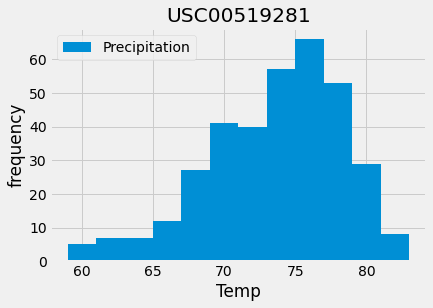

<Figure size 432x288 with 0 Axes>

In [30]:
hist = temp_df['tobs'].hist(bins=12)
plt.xlabel("Temp")
plt.ylabel("frequency")
plt.title("USC00519281")
plt.legend(["Precipitation"], loc='upper left')
plt.show()
plt.savefig("USC00519281")

## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017, 8, 20) - dt.timedelta(days=365)
end_date = dt.date(2017, 8, 30) - dt.timedelta(days=365)
print(start_date, end_date)


2016-08-20 2016-08-30


In [33]:
my_trip =calc_temps('2016-08-20', '2016-08-30')
my_trip

[(71.0, 78.08571428571429, 84.0)]

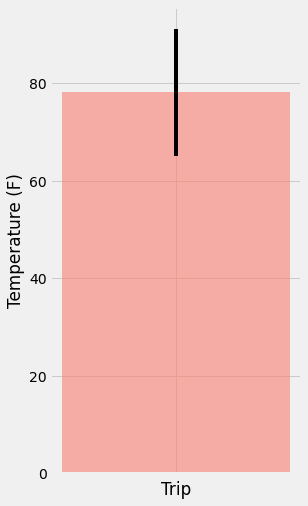

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = my_trip[0][2]-my_trip[0][0]
y_axis = my_trip[0][1]
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
bar_chart = ax.bar(1 , y_axis, color= 'salmon', tick_label='',yerr=error, alpha=0.6, align='center')
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature (F)")
plt.show()


In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
total_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall 

[('USC00516128', 7.760000000000001),
 ('USC00519281', 7.609999999999999),
 ('USC00513117', 4.1899999999999995),
 ('USC00514830', 2.55),
 ('USC00519523', 2.4),
 ('USC00519397', 0.69),
 ('USC00517948', 0.06)]

In [36]:
total_station = session.query(Station.name, Station.latitude, Station.longitude, Station.elevation,Measurement.station, func.sum(Measurement.prcp)).filter(Station.station==Measurement.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
for x in total_station:
    print(x)

('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 'USC00516128', 7.760000000000001)
('WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 'USC00519281', 7.609999999999999)
('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 'USC00513117', 4.1899999999999995)
('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 'USC00514830', 2.55)
('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 'USC00519523', 2.4)
('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 'USC00519397', 0.69)
('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 'USC00517948', 0.06)


In [37]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_list = [total_rainfall[0] for total_rainfall in total_rainfall]
station_list

['USC00516128',
 'USC00519281',
 'USC00513117',
 'USC00514830',
 'USC00519523',
 'USC00519397',
 'USC00517948']

In [38]:
data = engine.execute("select station, name, latitude, longitude, (select sum(measurement.prcp) from measurement where measurement.date >= '2016-08-20' and measurement.date <= '2016-08-30' group by measurement.station) as 'prcp_sum' from station order by 'prcp_sum'")
for x in data:
    print(x)
                      

('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 4.1899999999999995)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.1899999999999995)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 4.1899999999999995)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 4.1899999999999995)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 4.1899999999999995)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 4.1899999999999995)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 4.1899999999999995)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 4.1899999999999995)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 4.1899999999999995)


In [61]:
data = engine.execute("select station, name, latitude, longitude, (select sum(measurement.prcp) from measurement where station.station = measurement.station and measurement.date >= '2016-08-20' and measurement.date <= '2016-08-30' group by measurement.station) as 'prcp_sum' from station order by 'prcp_sum'")
for x in data:
    print(x)

('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.69)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.1899999999999995)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 2.55)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 0.06)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, None)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 2.4)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 7.609999999999999)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, None)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 7.760000000000001)


In [40]:
start_date = '2016-08-20'
end_date = '2016-08-30'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 7.760000000000001), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 7.609999999999999), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.1899999999999995), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.55), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.4), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.69), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]


In [41]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [42]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

trip_dates = pd.date_range(start='20/08/2016', end='30/08/2016', freq='D')

In [43]:
trip_month_day = trip_dates.strftime('%m-%d')


In [44]:
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
    
normals

[(68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0)]

In [45]:
df_02 =pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df_02["date"]= trip_dates
df_02.set_index('date', inplace=True)
df_02

,tmin,tavg,tmax
date,,,
2016-08-20,68.0,76.452830,82.0
2016-08-21,67.0,76.400000,83.0
2016-08-22,69.0,76.471698,84.0
2016-08-23,67.0,76.692308,87.0
2016-08-24,70.0,75.961538,84.0
2016-08-25,69.0,76.960784,82.0
2016-08-26,71.0,76.568627,84.0
2016-08-27,68.0,76.283019,84.0
2016-08-28,67.0,76.734694,86.0


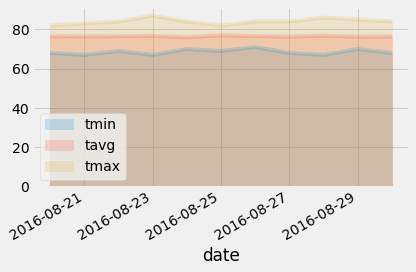

In [46]:
df_02.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()

In [47]:
#Temp Analysis 01
first_six_months = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.date >= '2016-01-01').\
filter(Measurement.date <= '2016-06-30').group_by(Measurement.station).all()
first_six_months

[('USC00513117', 72.0934065934066),
 ('USC00514830', 75.01785714285714),
 ('USC00516128', 69.38787878787879),
 ('USC00517948', 73.25742574257426),
 ('USC00519281', 70.53296703296704),
 ('USC00519397', 72.44505494505495),
 ('USC00519523', 73.44311377245509)]

In [48]:
first_df = pd.DataFrame(first_six_months, columns=['station', 'first_six_tobs'])
first_df

,station,first_six_tobs
0,USC00513117,72.093407
1,USC00514830,75.017857
2,USC00516128,69.387879
3,USC00517948,73.257426
4,USC00519281,70.532967
5,USC00519397,72.445055
6,USC00519523,73.443114


In [49]:
second_six_months = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.date > '2016-06-31').\
filter(Measurement.date <= '2016-12-31').group_by(Measurement.station).all()
second_six_months


[('USC00513117', 75.06521739130434),
 ('USC00514830', 78.09333333333333),
 ('USC00516128', 72.70454545454545),
 ('USC00517948', 76.70093457943925),
 ('USC00519281', 75.6413043478261),
 ('USC00519397', 76.52717391304348),
 ('USC00519523', 78.03389830508475)]

In [50]:
first_df['second_six_tobs'] = [second_six_months[1] for second_six_months in second_six_months]

In [51]:
print(f"compared to the first six motnhs of the year, second six months temp is higher")
first_df

compared to the first six motnhs of the year, second six months temp is higher


,station,first_six_tobs,second_six_tobs
0,USC00513117,72.093407,75.065217
1,USC00514830,75.017857,78.093333
2,USC00516128,69.387879,72.704545
3,USC00517948,73.257426,76.700935
4,USC00519281,70.532967,75.641304
5,USC00519397,72.445055,76.527174
6,USC00519523,73.443114,78.033898


In [52]:
month_str = "06"
june = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == month_str).group_by(Measurement.station).all()
june

[('USC00511918', 74.13939393939394),
 ('USC00513117', 74.05084745762711),
 ('USC00514830', 76.00537634408602),
 ('USC00516128', 71.9372197309417),
 ('USC00517948', 76.6554054054054),
 ('USC00518838', 73.39473684210526),
 ('USC00519281', 73.27118644067797),
 ('USC00519397', 77.55932203389831),
 ('USC00519523', 76.66810344827586)]

In [53]:
month_str = "06"
session.query(Measurement.date).\
    filter(func.strftime("%m", Measurement.date) == month_str).all()


[('2010-06-01'),
 ('2010-06-02'),
 ('2010-06-03'),
 ('2010-06-04'),
 ('2010-06-05'),
 ('2010-06-06'),
 ('2010-06-07'),
 ('2010-06-08'),
 ('2010-06-09'),
 ('2010-06-10'),
 ('2010-06-11'),
 ('2010-06-12'),
 ('2010-06-13'),
 ('2010-06-14'),
 ('2010-06-15'),
 ('2010-06-16'),
 ('2010-06-17'),
 ('2010-06-18'),
 ('2010-06-19'),
 ('2010-06-20'),
 ('2010-06-21'),
 ('2010-06-22'),
 ('2010-06-23'),
 ('2010-06-24'),
 ('2010-06-25'),
 ('2010-06-26'),
 ('2010-06-27'),
 ('2010-06-28'),
 ('2010-06-29'),
 ('2010-06-30'),
 ('2011-06-01'),
 ('2011-06-02'),
 ('2011-06-03'),
 ('2011-06-04'),
 ('2011-06-05'),
 ('2011-06-06'),
 ('2011-06-07'),
 ('2011-06-08'),
 ('2011-06-09'),
 ('2011-06-10'),
 ('2011-06-11'),
 ('2011-06-12'),
 ('2011-06-13'),
 ('2011-06-14'),
 ('2011-06-15'),
 ('2011-06-17'),
 ('2011-06-18'),
 ('2011-06-19'),
 ('2011-06-20'),
 ('2011-06-21'),
 ('2011-06-24'),
 ('2011-06-25'),
 ('2011-06-26'),
 ('2011-06-27'),
 ('2011-06-28'),
 ('2011-06-29'),
 ('2012-06-01'),
 ('2012-06-02'),
 ('2012-06-03'

In [54]:
dec_str = "12"
dec = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == dec_str).group_by(Measurement.station).all()
dec

[('USC00511918', 69.6842105263158),
 ('USC00513117', 71.06944444444444),
 ('USC00514830', 73.2247191011236),
 ('USC00516128', 69.29126213592232),
 ('USC00517948', 71.8348623853211),
 ('USC00518838', 72.42105263157895),
 ('USC00519281', 69.90322580645162),
 ('USC00519397', 71.10952380952381),
 ('USC00519523', 72.43333333333334)]

In [55]:
june_list = [june[1] for june in june]
dec_list = [dec[1] for dec in dec] 

In [56]:
np.mean(june_list)

74.85351018249018

In [57]:
np.mean(dec_list)

71.21907046377945

In [58]:
from scipy import stats

In [59]:
stats.ttest_ind(june_list, dec_list)

Ttest_indResult(statistic=4.615865424404701, pvalue=0.00028626292761018595)

In [60]:
print(f"there is no statistically significant between June and Dec temp cause the pvalue is {0.0002} ")

there is no statistically significant between June and Dec temp cause the pvalue is 0.0002 
